In [ ]:
#necessary libraries
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import sklearn.inspection
import plotly.express as px

#Preprocessing


Joining 2 datasets into one:

In [ ]:
red_df, white_df = pd.read_csv('winequality-red_NO_ALCOHOL.csv', sep = ';'), pd.read_csv('winequality-white_NO_ALCOHOL.csv', sep = ';')
red_df['type'],  white_df['type']= 'red' ,  'white'

df = pd.concat([red_df, white_df])

Detecting null values:

In [ ]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
quality                 0
type                    0
dtype: int64

Converting type column from string to integer:
red=0, white = 1

In [ ]:
categories = {}
for p in ['type']:
    df[p] = pd.Categorical(df[p])
    categories[p] = df[p].cat.categories

df['type'] = df[['type']].apply(lambda x: x.cat.codes)
categories


{'type': Index(['red', 'white'], dtype='object')}

Splitting dataset into training and testing datasets:

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=0.2)

train_X = train_df.drop(['quality'], axis = 1)
train_y = train_df.quality
test_X = test_df.drop(['quality'], axis = 1)
test_y =  test_df.quality

train_X.shape, test_X.shape

((5197, 11), (1300, 11))

#Random Forest

Let’s train a basic Random Forest with 100 trees and the minimal size of leaf nodes equal to 100.

In [ ]:
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, oob_score=True)
model.fit(train_X, train_y)

RandomForestRegressor(min_samples_leaf=100, oob_score=True)

In [ ]:
print("Mean Absolute Error of testing dataset = ", sklearn.metrics.mean_absolute_error(model.predict(test_X), test_y))
print("Mean Absolute Error of trainig dataset = ", sklearn.metrics.mean_absolute_error(model.predict(train_X), train_y))
print("Out of Bag Error of training dataset = ", sklearn.metrics.mean_absolute_error(model.oob_prediction_, train_y))


Mean Absolute Error of testing dataset =  0.5834052244481425
Mean Absolute Error of trainig dataset =  0.5592789385682757
Out of Bag Error of training dataset =  0.5754998508451644


One of adventages of random forest is we can get much better results by just increasing the number of trees and it will not cause to overfitting.o. Since we are averaging not correlated errors, we cannot overfit the model by adding more trees. Quality will improve asymptotically with the increase in the number of trees. Let's see how our model improves by increasing

In [ ]:
import tqdm

results_list = []
for min_samples_leaf in [1, 10, 100, 500]:
    print('min_samples_leaf = %d' % min_samples_leaf)
    data_points = []
    for n in tqdm.tqdm(list(range(1, 151))):
        clf = sklearn.ensemble.RandomForestRegressor(n, min_samples_leaf=min_samples_leaf)
        clf.fit(train_X, train_y)

        data_points.append({
                'min_samples_leaf': min_samples_leaf,
                'num_trees': n,
                'test_mae': sklearn.metrics.mean_absolute_error(clf.predict(test_X), test_y),
                'test_mse': sklearn.metrics.mean_squared_error(clf.predict(test_X), test_y),
                'train_mae': sklearn.metrics.mean_absolute_error(clf.predict(train_X), train_y),
                'train_mse': sklearn.metrics.mean_squared_error(clf.predict(train_X), train_y)})

    results_list.append(pd.DataFrame(data_points))

min_samples_leaf = 1


100%|██████████| 150/150 [06:48<00:00,  2.72s/it]


min_samples_leaf = 10


100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


min_samples_leaf = 100


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


min_samples_leaf = 500


100%|██████████| 150/150 [01:21<00:00,  1.85it/s]


In [ ]:
final_df = pd.concat(results_list)
px.line(final_df.pivot(index = 'num_trees', columns = 'min_samples_leaf', values = 'test_mae'))

In [ ]:
results_list = final_df.pivot(index = 'num_trees', columns = 'min_samples_leaf', values = 'test_mae')[[100]][:101]
results_list['moving_avg'] = results_list[100].rolling(5, min_periods = 1).mean()

fig = px.line( results_list[[100]], title = 'Mean Absolute Error, min_samples_leaf = 100', labels = {'value': 'MAE', 'num_trees': 'number of trees'} )

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_list.index, y=results_list[100], name='Real value'))
fig.add_trace(go.Scatter(x=results_list.index, y=results_list['moving_avg'], name='moving average', line=dict(color='darkorange', width=2.5, dash = 'dot')))

fig.update_layout(title='Mean Absolute Error =100, Minimum Leaf Smaples = 100', xaxis_title='Number of Trees', yaxis_title='MAE', width=800, height=500)

In [ ]:
results_list2 = []
for max_depth in [1, 3, 5, 8, 10, 15, 20, 30]:
    print('maximum depth = %d' % max_depth)
    data_points2 = []
    for n in tqdm.tqdm(list(range(1, 150))):
        clf = sklearn.ensemble.RandomForestRegressor(n, min_samples_leaf=min_samples_leaf)
        clf.fit(train_X, train_y)

        data_points2.append({
                'max_depth': max_depth,
                'num_trees': n,
                'tets_mae': sklearn.metrics.mean_absolute_error(clf.predict(test_X), test_y),
                'test_mse': sklearn.metrics.mean_squared_error(clf.predict(test_X), test_y),
                'train_mae': sklearn.metrics.mean_absolute_error(clf.predict(train_X), train_y),
                'train_mse': sklearn.metrics.mean_squared_error(clf.predict(train_X), train_y)})

    results_list2.append(pd.DataFrame(data_points2))

maximum depth = 1


100%|██████████| 149/149 [01:23<00:00,  1.78it/s]


maximum depth = 3


100%|██████████| 149/149 [01:21<00:00,  1.83it/s]


maximum depth = 5


100%|██████████| 149/149 [01:20<00:00,  1.86it/s]


maximum depth = 8


100%|██████████| 149/149 [01:21<00:00,  1.82it/s]


maximum depth = 10


100%|██████████| 149/149 [01:20<00:00,  1.85it/s]


maximum depth = 15


100%|██████████| 149/149 [01:21<00:00,  1.82it/s]


maximum depth = 20


100%|██████████| 149/149 [01:21<00:00,  1.83it/s]


maximum depth = 30


100%|██████████| 149/149 [01:21<00:00,  1.83it/s]


In [ ]:
final2_df = pd.concat(results_list2)

px.line(final2_df.pivot(index = 'num_trees', columns = 'max_depth', values = 'tets_mae'))

#Interpreting model

In [ ]:
%%time
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, oob_score=True)
model.fit(train_X, train_y)

CPU times: user 1.2 s, sys: 6.95 ms, total: 1.21 s
Wall time: 1.21 s


RandomForestRegressor(min_samples_leaf=100, oob_score=True)

#Feature Importances

In [ ]:
def visualize_feature_importance(model, feature_names, importance_threshold=None):
    # Create DataFrame
    data = list(zip(feature_names, model.feature_importances_))
    importance_df = pd.DataFrame(data, columns=['feature', 'importance'])
    importance_df = importance_df.set_index('feature').sort_values('importance', ascending=False)

    # Apply optional threshold
    if importance_threshold is not None:
        importance_df = importance_df[importance_df['importance'] > importance_threshold]

    # Plot feature importances
    figure = px.bar(importance_df, text_auto='.3f', title='Feature Importances', width=800, height=600 )
    figure.show()

visualize_feature_importance(model, train_X.columns)

###Looking for highly correlated features which are redundant and can be removed:

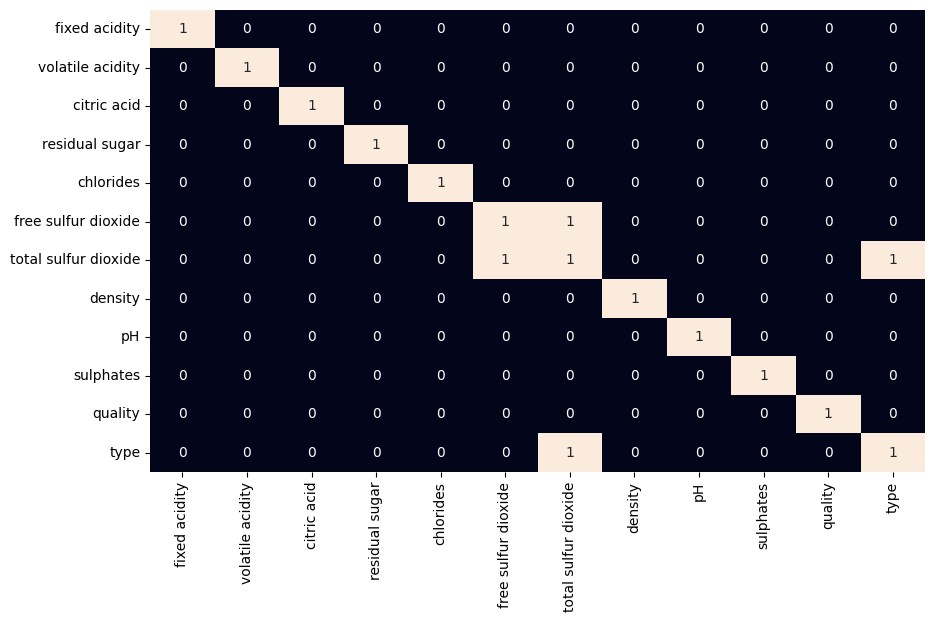

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr()>0.7, annot=True, cbar=False)
plt.show()

So we can see that correlation between  the ‘total sulphur dioxide’ and ‘free sulphur dioxide‘ are highly correlated features(more than 0.7) so, we will remove one of them:

In [ ]:
df = df.drop('total sulfur dioxide', axis=1)

#Partial Dependencies


In [ ]:
%%time
clf = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=50)
clf.fit(train_X, train_y)

CPU times: user 1.42 s, sys: 1.98 ms, total: 1.42 s
Wall time: 1.42 s


RandomForestRegressor(min_samples_leaf=50)

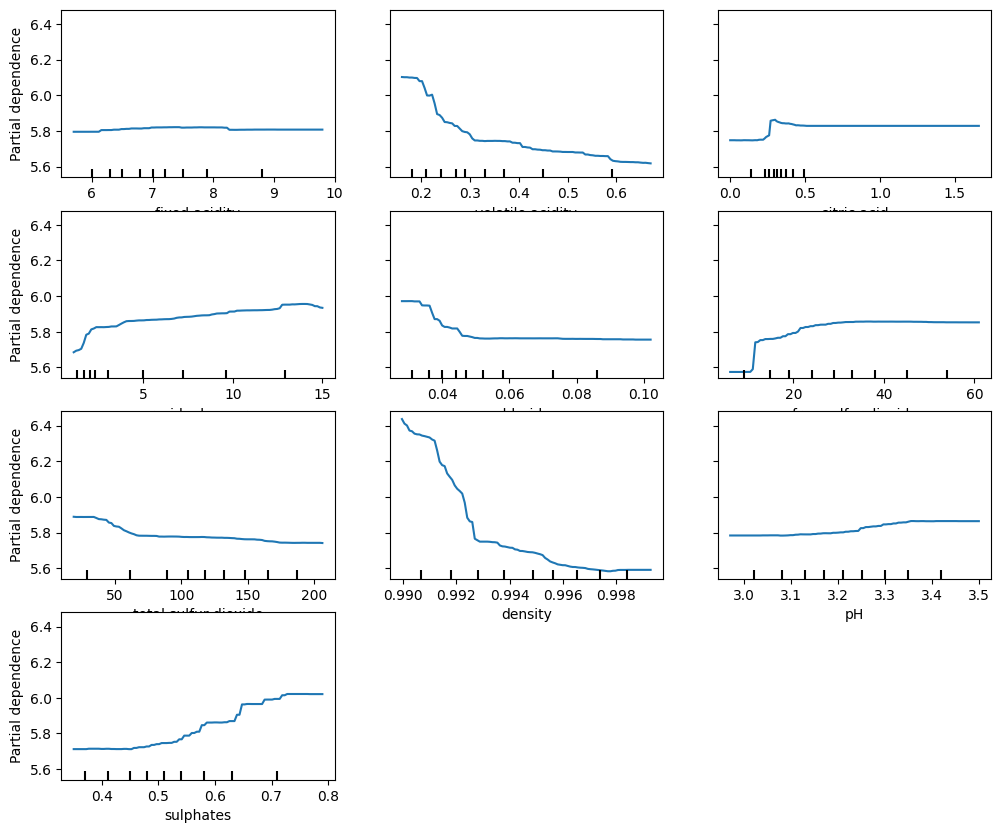

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 10
sklearn.inspection.PartialDependenceDisplay.from_estimator(clf, train_X, range(10))

##Confidence of predictions

Text(0.5, 1.0, 'Distribution of Prediction Standard Deviations')

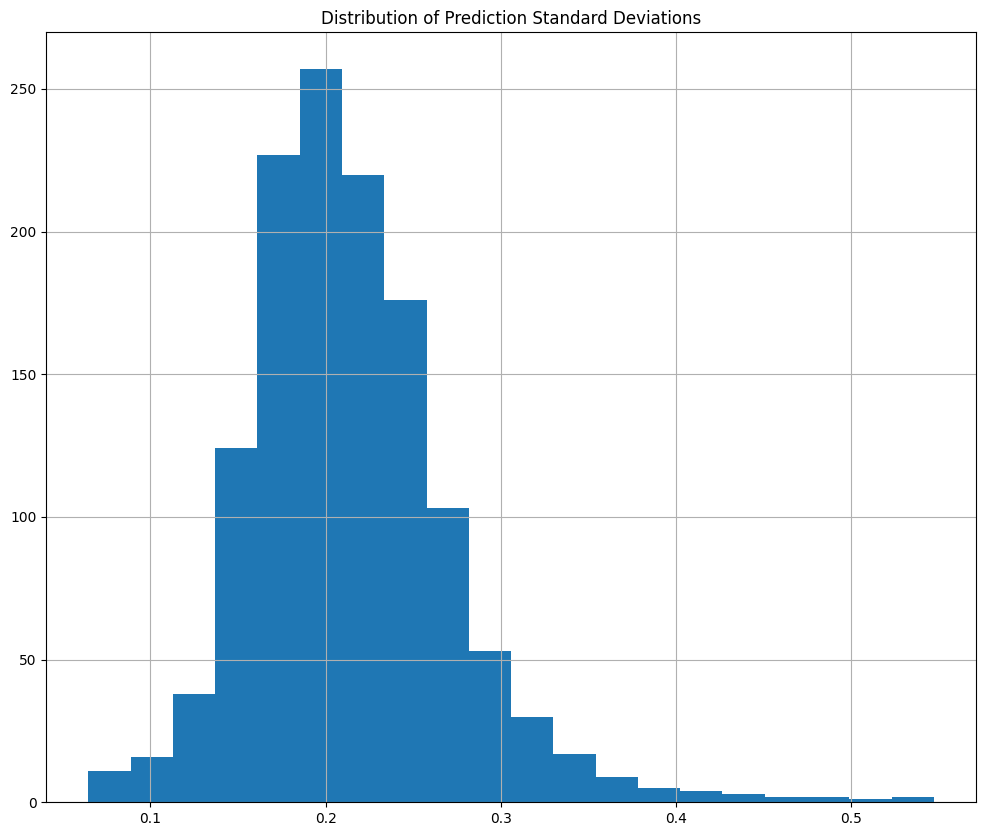

In [ ]:
# Making predictions on the test set using the trained model
predictions_test = model.predict(test_X)

# Calculating the mean and standard deviation of predictions from each tree in the ensemble
tree_predictions = [dt.predict(test_X.values) for dt in model.estimators_]
predictions_mean = np.mean(tree_predictions, axis=0)
predictions_std_dev = np.std(tree_predictions, axis=0)

# Assigning predictions and their statistics to the test dataframe
test_df['predicted_values'] = predictions_test
test_df['mean_prediction'] = predictions_mean
test_df['std_dev_prediction'] = predictions_std_dev

# Plotting the distribution of prediction standard deviations
ax = test_df['std_dev_prediction'].hist(bins=20)
ax.set_title('Distribution of Prediction Standard Deviations')

